In [83]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
#PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#V1
#PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V2
PHASE_COLORS = ['#c8abc9','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V3

#dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'Z:\\Behavioor'

current_version = 0 #June 23nd, 2023
current_version = 1 # July 21st 2023

In [84]:
animals = np.concatenate((dualanimalnames,[]))

In [85]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\insan\Desktop\EphysAnalysis\Notebooks\TH\../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
po

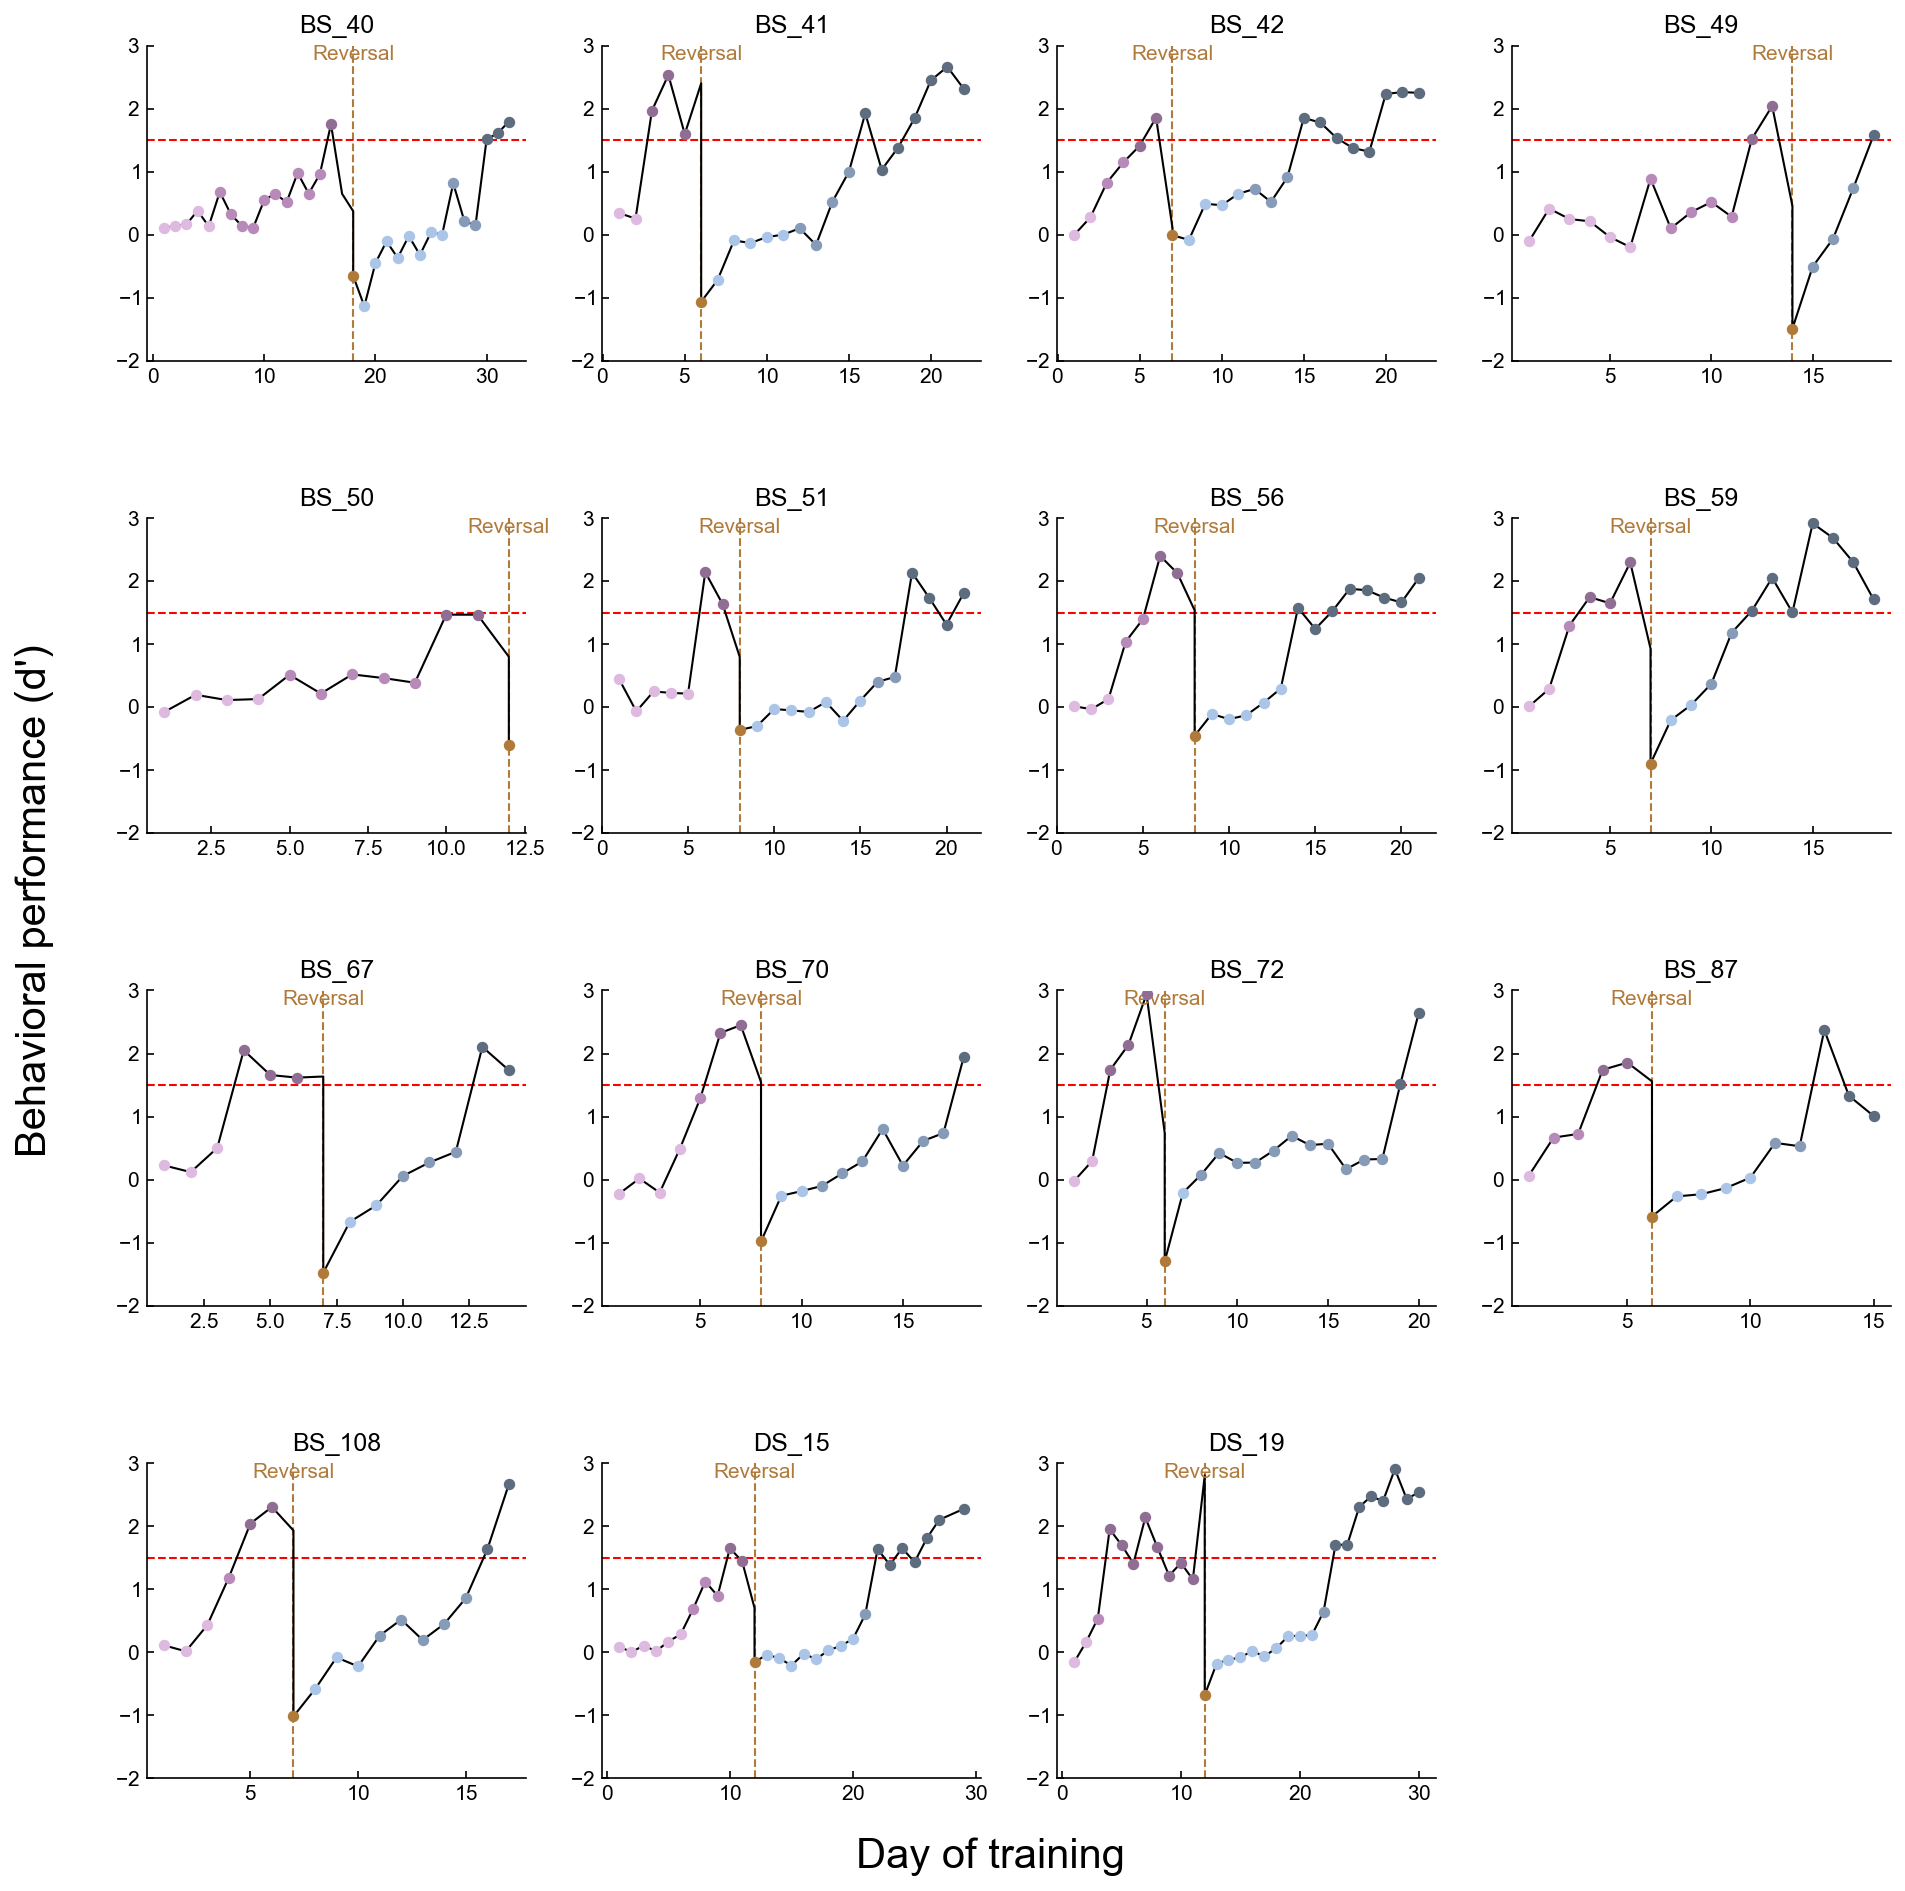

In [86]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)
#plt.savefig(os.path.join('D:\\\\TempFigures','All ephys animals learning phases.pdf'),transparent=False,facecolor="white")

In [87]:
pre_early_dps = []
pre_early_pcs = []
pre_late_dps = []
pre_late_pcs = []
pre_expert_dps = []
pre_expert_pcs = []
post_early_dps = []
post_early_pcs = []
post_late_dps = []
post_late_pcs = []
post_expert_dps = []
post_expert_pcs = []

for animal in tqdm(animals):
    
    reversal = np.nan
    second_reversal = np.nan

    days = list(np.unique(list(animalBehaviors[animal].sessions.keys())))
    if hasattr(animalBehaviors[animal],'reversal') and np.isfinite(animalBehaviors[animal].reversal):
        reversal = animalBehaviors[animal].reversal
        days.append(reversal)
    if hasattr(animalBehaviors[animal],'second_reversal') and np.isfinite(animalBehaviors[animal].second_reversal):
        second_reversal = animalBehaviors[animal].second_reversal
        days.append(second_reversal)
    days = np.sort(days)
    #Needs days
    expert_days = np.concatenate(( learning_phases[animal].pre_expert_days,learning_phases[animal].post_expert_days,learning_phases[animal].second_expert_days ))
    dp_list,pc_list = ilep.getPCDPfromBehavior(animalBehaviors,animal,days,expert_days)
    
    this_pre_early_dps = []
    this_pre_early_pcs = []
    this_pre_late_dps = []
    this_pre_late_pcs = []
    this_pre_expert_dps = []
    this_pre_expert_pcs = []
    this_post_early_dps = []
    this_post_early_pcs = []
    this_post_late_dps = []
    this_post_late_pcs = []
    this_post_expert_dps = []
    this_post_expert_pcs = []
    
    for day_idx,day in enumerate(days):
        if day in learning_phases[animal].pre_early_days:
            this_pre_early_dps.append(dp_list[day_idx])
            this_pre_early_pcs.append(pc_list[day_idx])
        if day in learning_phases[animal].pre_late_days:
            this_pre_late_dps.append(dp_list[day_idx])
            this_pre_late_pcs.append(pc_list[day_idx])
        if day in learning_phases[animal].pre_expert_days:
            this_pre_expert_dps.append(dp_list[day_idx])
            this_pre_expert_pcs.append(pc_list[day_idx])
        if day in learning_phases[animal].post_early_days:
            this_post_early_dps.append(dp_list[day_idx])
            this_post_early_pcs.append(pc_list[day_idx])
        if day in learning_phases[animal].post_late_days:
            this_post_late_dps.append(dp_list[day_idx])
            this_post_late_pcs.append(pc_list[day_idx])
        if day in learning_phases[animal].post_expert_days:
            this_post_expert_dps.append(dp_list[day_idx])
            this_post_expert_pcs.append(pc_list[day_idx])
            
    #print(f"animal {animal} has pre_expert dp of {np.nanmean(this_pre_expert_dps)}")
    print(f"animal {animal} has post_expert dp of {np.nanmean(this_post_expert_dps)}")
            
    pre_early_dps.append(np.mean(this_pre_early_dps))
    pre_early_pcs.append(np.mean(this_pre_early_pcs))
    pre_late_dps.append(np.mean(this_pre_late_dps))
    pre_late_pcs.append(np.mean(this_pre_late_pcs))
    pre_expert_dps.append(np.mean(this_pre_expert_dps))
    pre_expert_pcs.append(np.mean(this_pre_expert_pcs))
    post_early_dps.append(np.mean(this_post_early_dps))
    post_early_pcs.append(np.mean(this_post_early_pcs))
    post_late_dps.append(np.mean(this_post_late_dps))
    post_late_pcs.append(np.mean(this_post_late_pcs))
    post_expert_dps.append(np.mean(this_post_expert_dps))
    post_expert_pcs.append(np.mean(this_post_expert_pcs))

  0%|          | 0/15 [00:00<?, ?it/s]C:\Users\insan\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\insan\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
 20%|██        | 3/15 [00:00<00:00, 27.29it/s]C:\Users\insan\AppData\Local\Temp\ipykernel_9320\2066841962.py:65: RuntimeWarning: Mean of empty slice
  print(f"animal {animal} has post_expert dp of {np.nanmean(this_post_expert_dps)}")


animal BS_40 has post_expert dp of 1.6365910169816509
animal BS_41 has post_expert dp of 1.9423274053543729
animal BS_42 has post_expert dp of 1.8232575076546031
animal BS_49 has post_expert dp of 1.5721088955828284
animal BS_50 has post_expert dp of nan
animal BS_51 has post_expert dp of 1.7454054590851742
animal BS_56 has post_expert dp of 1.6883300359427946


 80%|████████  | 12/15 [00:00<00:00, 30.64it/s]

animal BS_59 has post_expert dp of 2.098026550743687
animal BS_67 has post_expert dp of 1.9200777968902167
animal BS_70 has post_expert dp of 1.9457918755241324
animal BS_72 has post_expert dp of 2.0805116878111574
animal BS_87 has post_expert dp of 1.5701600440753394
animal BS_108 has post_expert dp of 2.144656977787972
animal DS_15 has post_expert dp of 1.7518792508804795


100%|██████████| 15/15 [00:00<00:00, 26.80it/s]

animal DS_19 has post_expert dp of 2.3045935085255014


In [88]:
pre_expert_dps

[1.75068607125217,
 2.030798499298092,
 1.6319029450438869,
 1.7793328270957067,
 1.4652176544509794,
 1.8876496314140125,
 2.2604974964258644,
 1.8949021672512423,
 1.775593373282697,
 2.3882249494027232,
 2.2729786695616068,
 1.7987534074888898,
 2.1704551963933145,
 1.5429254449065075,
 1.5790961600638345]

In [89]:
print(f"pre early: {np.nanmean(pre_early_dps)} +/- {np.std(ilep.rmnan(pre_early_dps))}")
print(f"pre late: {np.nanmean(pre_late_dps)} +/- {np.std(ilep.rmnan(pre_late_dps))}")
print(f"pre expert: {np.nanmean(pre_expert_dps)} +/- {np.std(ilep.rmnan(pre_expert_dps))}")
print(f"post early: {np.nanmean(post_early_dps)} +/- {np.std(ilep.rmnan(post_early_dps))}")
print(f"post late: {np.nanmean(post_late_dps)} +/- {np.std(ilep.rmnan(post_late_dps))}")
print(f"post expert: {np.nanmean(post_expert_dps)} +/- {np.std(ilep.rmnan(post_expert_dps))}")

pre early: 0.1303006366835917 +/- 0.08624332451809763
pre late: 0.8613900754532011 +/- 0.3344997042217228
pre expert: 1.8819342995554351 +/- 0.2765198847274632
post early: -0.13089371609035388 +/- 0.20864855575426516
post late: 0.46007178680606214 +/- 0.18842188543260296
post expert: 1.8731227152028507 +/- 0.21904894927375118


In [90]:
postexperts = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

In [91]:
for animal in postexperts:
    print(learning_phases[animal].post_expert_days)

[30 31 32]
[16 17 18 19 20 21 22]
[15 16 17 18 19 20 21 22]
[18]
[]
[18 19 20 21]
[14 15 16 17 18 19 20 21]
[12 13 14 15 16 17 18]
[13 14]
[18]
[19 20]
[13 14 15]
[16 17]
[22 23 24 25 26 27 29]
[23 24 25 26 27 28 29 30]


In [92]:
(30+16+15+18+18+14+12+13+18+19+13+16+22+23)/14

17.642857142857142

In [93]:
days_tolearn = [30,16,15,18,18,14,12,13,18,19,13,16,22,23]

# days to learn

C:\Users\insan\AppData\Local\Temp\ipykernel_9320\2768046951.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
meta NOT subset; don't know how to subset; dropped


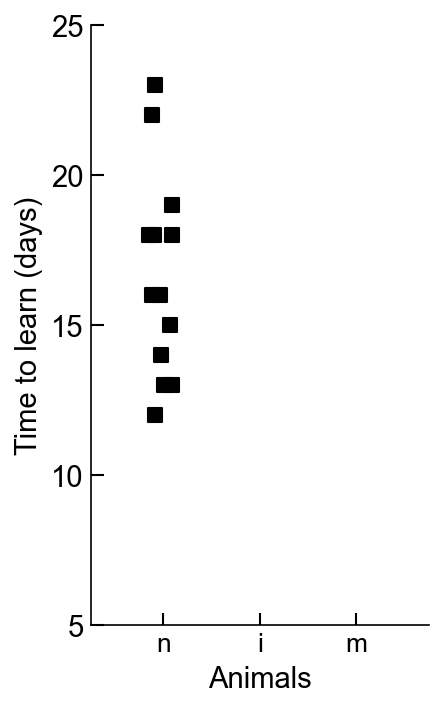

In [94]:
stdfont = 14
stdyfrac = 0.06

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(2.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0
################################################################################################################

#Plot figure

data = [days_tolearn]
labels = ['Animals']
numCon = len(data)

sz = 35
width = 0.3

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    

    if idx == 0:
        ax.scatter(X-switch_offset,Y,s=50,color='black',marker='s')
    else:
        ax.scatter(X-switch_offset,Y,s=50,color='white',edgecolor='black',marker='s')
        

        
################################################################################################################

labels = 'Animals'

ax.set_ylim([5,25])
ax.set_yticks([5,10,15,20,25])
ax.set_yticklabels(['5','10','15','20','25'])
ylab = ax.set_ylabel('Time to learn (days)')

ax.set_xlim([-0.75-switch_offset,2.75+switch_offset])
# ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset])
ax.set_xticklabels(labels)
xlab = ax.set_xlabel(labels)



ax.tick_params(direction='in', length=6, width=1)
ax.axhline(0,color='black',lw=1)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass


artists = [ylab,t1]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Time to learn.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

C:\Users\insan\AppData\Local\Temp\ipykernel_9320\1663211526.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels)
meta NOT subset; don't know how to subset; dropped


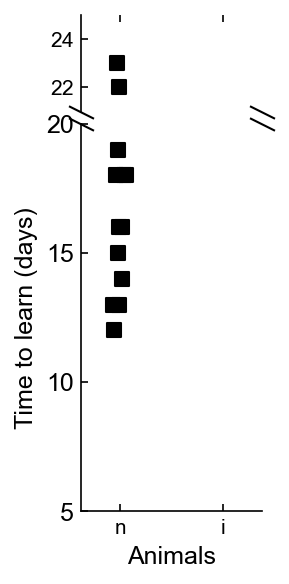

In [108]:
stdfont = 14
stdyfrac = 0.06

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(1.55,4.3),gridspec_kw = {'height_ratios':[1,4]})
fig.subplots_adjust(hspace=0.05)  # adjust space between axes
################################################################################################################

#Plot figure

data = [days_tolearn]
labels = ['Animals']
numCon = len(data)

sz = 35
width = 0.3

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    

    ax1.scatter(X-switch_offset,Y,s=50,color='black',marker='s')
    ax2.scatter(X-switch_offset,Y,s=50,color='black',marker='s')



        
################################################################################################################

labels = 'Animals'

ax2.set_ylim([5,20])
ax2.set_yticks([5,10,15,20])
ax2.set_yticklabels(['5','10','15','20'],fontsize = 12)
ax2.set_ylabel('Time to learn (days)',fontsize = 12)

ax2.set_xlim([-0.75-switch_offset,2.75+switch_offset])
ax2.set_xticklabels(labels)
ax2.set_xlabel(labels,fontsize = 12)

ax1.set_ylim([21,25])

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()


d = -0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Time to learn2.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

C:\Users\insan\AppData\Local\Temp\ipykernel_9320\1087876681.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels)
meta NOT subset; don't know how to subset; dropped


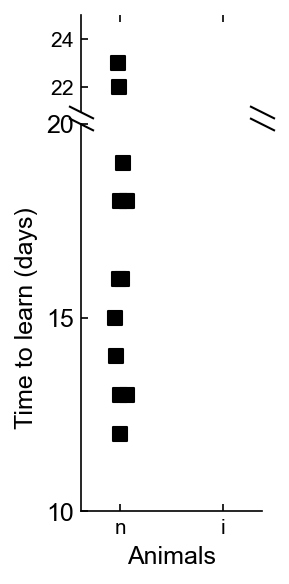

In [109]:
stdfont = 14
stdyfrac = 0.06

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(1.55,4.3),gridspec_kw = {'height_ratios':[1,4]})
fig.subplots_adjust(hspace=0.05)  # adjust space between axes
################################################################################################################

#Plot figure

data = [days_tolearn]
labels = ['Animals']
numCon = len(data)

sz = 35
width = 0.3

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    

    ax1.scatter(X-switch_offset,Y,s=50,color='black',marker='s')
    ax2.scatter(X-switch_offset,Y,s=50,color='black',marker='s')



        
################################################################################################################

labels = 'Animals'

ax2.set_ylim([10,20])
ax2.set_yticks([10,15,20])
ax2.set_yticklabels(['10','15','20'],fontsize = 12)
ax2.set_ylabel('Time to learn (days)',fontsize = 12)

ax2.set_xlim([-0.75-switch_offset,2.75+switch_offset])
ax2.set_xticklabels(labels)
ax2.set_xlabel(labels,fontsize = 12)

ax1.set_ylim([21,25])

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()


d = -0.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Time to learn3.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [7]:
#pre_early_dps,pre_late_dps,pre_expert_dps,post_early_dps,post_late_dps,post_expert_dps

In [8]:
Data = SimpleNamespace()
Data.preearly =pre_early_dps
Data.prelate = pre_late_dps
Data.preexpert = pre_expert_dps
Data.postearly = post_early_dps
Data.postlate = post_late_dps
Data.postexpert = post_expert_dps

In [9]:
ilep.nonparametricIndependentStatsCompareToPrevious(Data)

            Source         SS    DF         MS           F         p-unc  \
0            phase  24.973767   3.0   8.324589  137.307076  8.702596e-35   
1          context  23.112941   1.0  23.112941  381.228463  2.247304e-35   
2  phase * context   2.617998   3.0   0.872666   14.393889  7.877932e-08   
3         Residual   5.880871  97.0   0.060628         NaN           NaN   

        np2  
0  0.809401  
1  0.797168  
2  0.308041  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.000011  0.000028 -6.435662
8     post-late  baseline  experimental  0.000041  0.000041 -2.765954
9    pre-expert  baseline  experimental  0.000021  0.000028 -3.139927
10     pre-late  baseline  experimental  0.000021  0.000028 -2.993684
key preearly has 15 non-nan elements
key prelate has 11 non-nan elements
key preexpert has 15 non-nan elements
key postearly has 13 non-nan elements
key postlate has 13 non-nan elements
key postexpe

,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,613.5,two-sided,3.120412e-06,6.240825e-06,fdr_bh,1.710328
1,phase,-,post-expert,pre-expert,False,False,286.0,two-sided,2.511399e-01,2.511399e-01,fdr_bh,-0.372956
2,phase,-,post-expert,pre-late,False,False,571.0,two-sided,9.408998e-05,1.411350e-04,fdr_bh,1.205378
3,phase,-,post-late,pre-expert,False,False,26.0,two-sided,1.192319e-08,7.153915e-08,fdr_bh,-2.554469
4,phase,-,post-late,pre-late,False,False,225.0,two-sided,3.950536e-02,4.740643e-02,fdr_bh,-0.675837
5,phase,-,pre-expert,pre-late,False,False,615.5,two-sided,3.965210e-07,1.189563e-06,fdr_bh,1.899967
6,context,-,baseline,experimental,False,False,306.0,two-sided,6.520217e-12,NaN,NaN,-1.770870
7,phase * context,post-expert,baseline,experimental,False,False,0.0,two-sided,1.125106e-05,2.777443e-05,fdr_bh,-6.435662
8,phase * context,post-late,baseline,experimental,False,False,4.0,two-sided,4.085966e-05,4.085966e-05,fdr_bh,-2.765954
9,phase * context,pre-expert,baseline,experimental,False,False,0.0,two-sided,2.083082e-05,2.777443e-05,fdr_bh,-3.139927


In [10]:
# 0.05 = *
# 0.01 = **
# 0.001 = ***
# 0.0001 = ****

In [11]:
2.777443e-05 	 <0.0001

True

In [15]:
post_expert_dps

[1.6365910169816509,
 1.9423274053543729,
 1.8232575076546031,
 1.5721088955828284,
 nan,
 1.7454054590851742,
 1.6883300359427946,
 2.098026550743687,
 1.9200777968902167,
 1.9457918755241324,
 2.0805116878111574,
 1.5701600440753394,
 2.144656977787972,
 1.7518792508804795,
 2.3045935085255014]

In [16]:
# ['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_51' 'BS_56' 'BS_67' 'BS_70' 'BS_87'
#  'DS_15' 'DS_19']

# V1

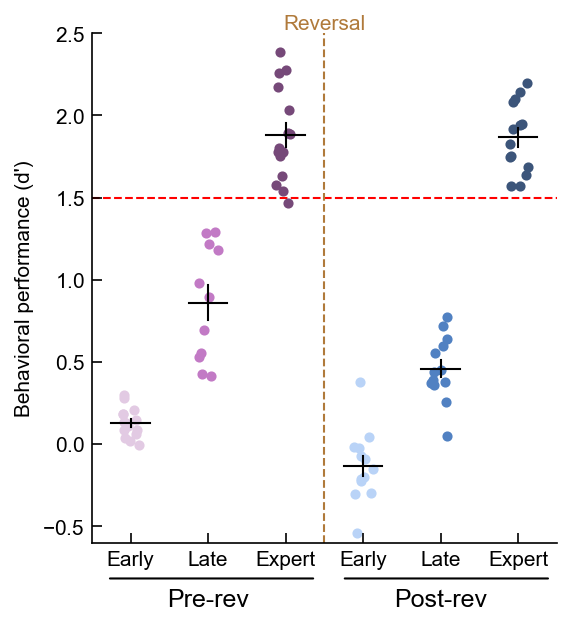

In [86]:
fig, ax = plt.subplots(figsize=(4,4.5))
data = [pre_early_dps,pre_late_dps,pre_expert_dps,post_early_dps,post_late_dps,post_expert_dps]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

width = 0.25
for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    ax.scatter(X,Y,s=15,color=PHASE_COLORS[idx])
    
    mean = np.mean(Y)
    SEM = sem(Y)
    ax.plot([idx-width,idx+width],[mean]*2,color='k',lw=1)
    ax.plot([idx]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

ax.set_ylim([-0.6,2.5])
ax.set_ylabel('Behavioral performance (d\')')

#ax.text(5,ax.get_ylim()[0],f"N = {len(animals)}\n",horizontalalignment='center',verticalalignment='bottom')
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
ax.axvline(2.5,linestyle='--',color=SWITCH_COLOR,lw=1,zorder=-9)
ax.axhline(1.5,linestyle='--',color='red',lw=1,zorder=-10)

ax.tick_params(length=5)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -0.8749628968456478, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
ax.text(xtick_pos_post, -0.8749628968456478, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.485, -0.07),arrowprops=dict(arrowstyle='-', color='k'))
ax.annotate('', xy=(0.535, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='k'))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Performance over phases dprime V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

# V2

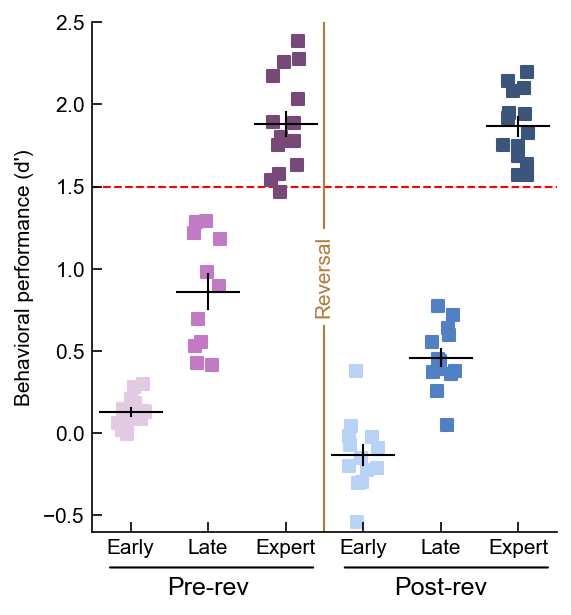

In [6]:
fig, ax = plt.subplots(figsize=(4,4.5))
data = [pre_early_dps,pre_late_dps,pre_expert_dps,post_early_dps,post_late_dps,post_expert_dps]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

sz = 35
width = 0.4

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    ax.scatter(X,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
    
    mean = np.mean(Y)
    SEM = sem(Y)
    ax.plot([idx-width,idx+width],[mean]*2,color='k',lw=1)
    ax.plot([idx]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

ax.set_ylim([-0.6,2.5])
ax.set_ylabel('Behavioral performance (d\')')

rev = 2.5
size = 0.3
center = np.mean(ax.get_ylim())
ax.text(rev,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
ax.plot([rev,rev],[ax.get_ylim()[0],center-size],color=SWITCH_COLOR,lw=1,linestyle='-')
ax.plot([rev,rev],[center+size,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')

ax.axhline(1.5,linestyle='--',color='red',lw=1,zorder=-10)

ax.tick_params(length=5)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -0.8749628968456478, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
ax.text(xtick_pos_post, -0.8749628968456478, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.485, -0.07),arrowprops=dict(arrowstyle='-', color='k'))
ax.annotate('', xy=(0.535, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='k'))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Performance over phases dprime V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

# V3

meta NOT subset; don't know how to subset; dropped


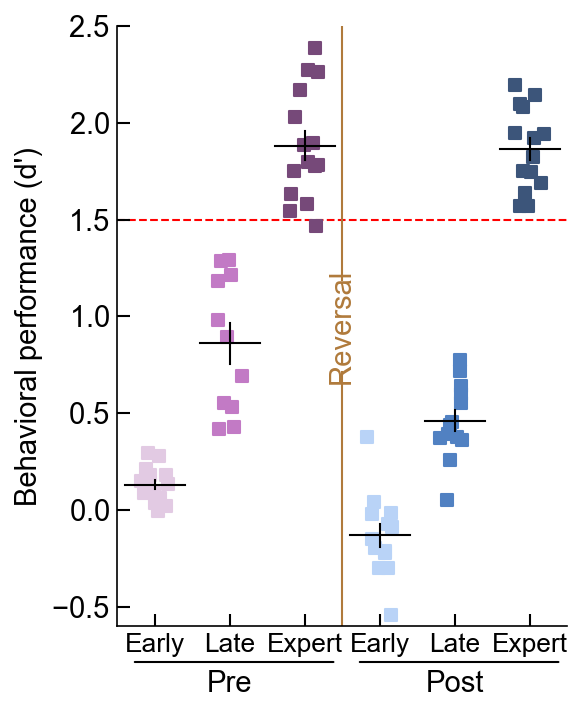

In [13]:
stdfont = 14
stdyfrac = 0.06

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)

################################################################################################################

#Plot figure

data = [pre_early_dps,pre_late_dps,pre_expert_dps,post_early_dps,post_late_dps,post_expert_dps]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

sz = 35
width = 0.4

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    ax.scatter(X,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
    
    mean = np.mean(Y)
    SEM = sem(Y)
    ax.plot([idx-width,idx+width],[mean]*2,color='k',lw=1)
    ax.plot([idx]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([-0.6,2.5])
ylab = ax.set_ylabel('Behavioral performance (d\')')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
ax.axhline(1.5,linestyle='--',color='red',lw=1,zorder=-10)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-Y*0.25],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+Y*0.25],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\sum_behavior.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

# V4

In [7]:
stdfont = 14
stdyfrac = 0.06

meta NOT subset; don't know how to subset; dropped


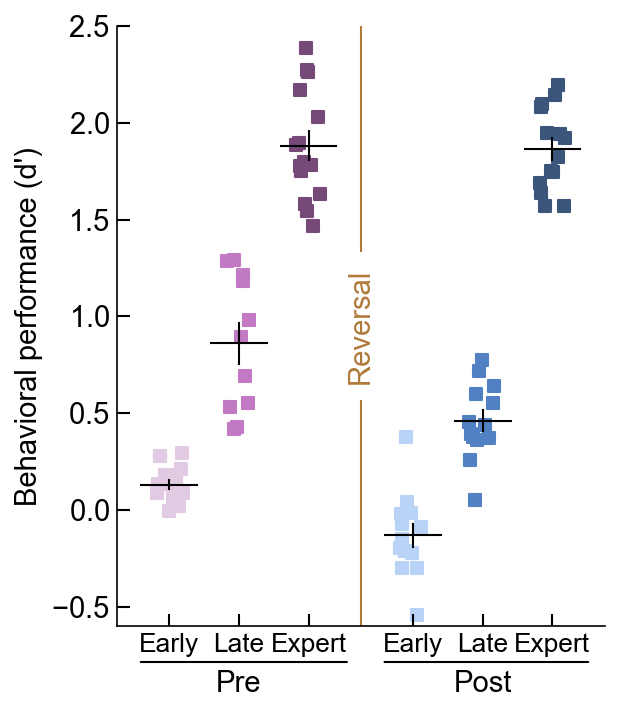

In [19]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
#switch_offset = 0
################################################################################################################

#Plot figure

data = [pre_early_dps,pre_late_dps,pre_expert_dps,post_early_dps,post_late_dps,post_expert_dps]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

sz = 35
width = 0.4

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)
    if idx<3:
        ax.scatter(X-switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
        
    else:
        ax.scatter(X+switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx+switch_offset-width,idx+switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx+switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    
    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([-0.6,2.5])
ylab = ax.set_ylabel('Behavioral performance (d\')')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\sum_behavior.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

# V5

meta NOT subset; don't know how to subset; dropped


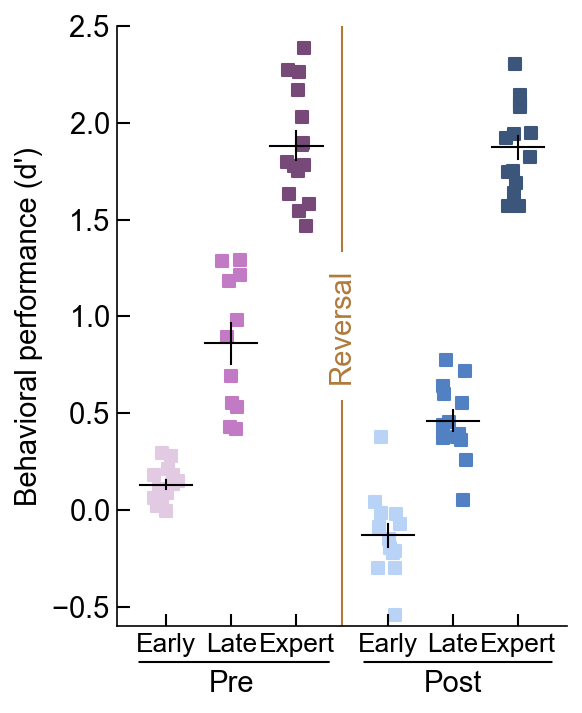

In [12]:

stdfont = 14
stdyfrac = 0.06

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.2
#switch_offset = 0
################################################################################################################

#Plot figure

data = [pre_early_dps,pre_late_dps,pre_expert_dps,post_early_dps,post_late_dps,post_expert_dps]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

sz = 35
width = 0.4

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)
    if idx<3:
        ax.scatter(X-switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
        
    else:
        ax.scatter(X+switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx+switch_offset-width,idx+switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx+switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    
    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([-0.6,2.5])
ylab = ax.set_ylabel('Behavioral performance (d\')')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\sum_behavior.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

# V6

meta NOT subset; don't know how to subset; dropped


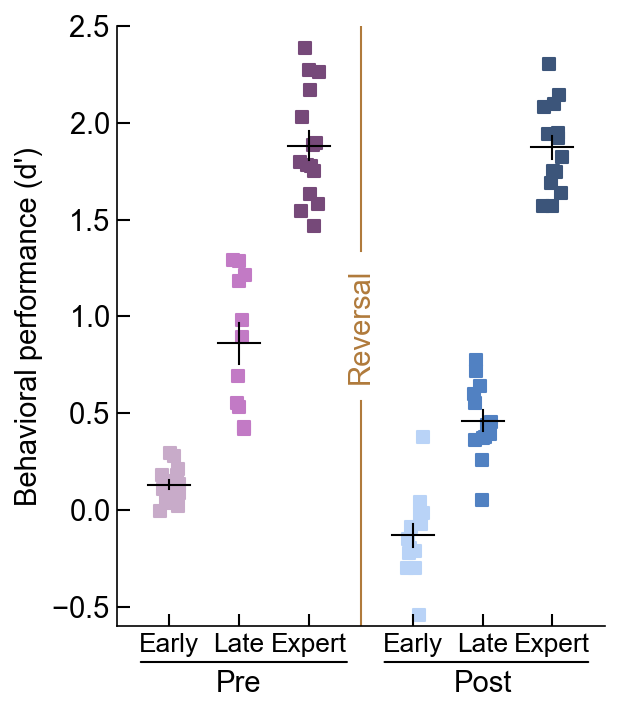

In [20]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
#switch_offset = 0
################################################################################################################

#Plot figure

data = [pre_early_dps,pre_late_dps,pre_expert_dps,post_early_dps,post_late_dps,post_expert_dps]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

sz = 35
width = 0.3

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)
    if idx<3:
        ax.scatter(X-switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
        
    else:
        ax.scatter(X+switch_offset,Y,s=sz,color=PHASE_COLORS[idx],marker='s')
        ax.plot([idx+switch_offset-width,idx+switch_offset+width],[mean]*2,color='k',lw=1)
        ax.plot([idx+switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    
    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([-0.6,2.5])
ylab = ax.set_ylabel('Behavioral performance (d\')')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.54, -stdyfrac), xycoords='axes fraction', xytext=(0.975, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\sum_behavior.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

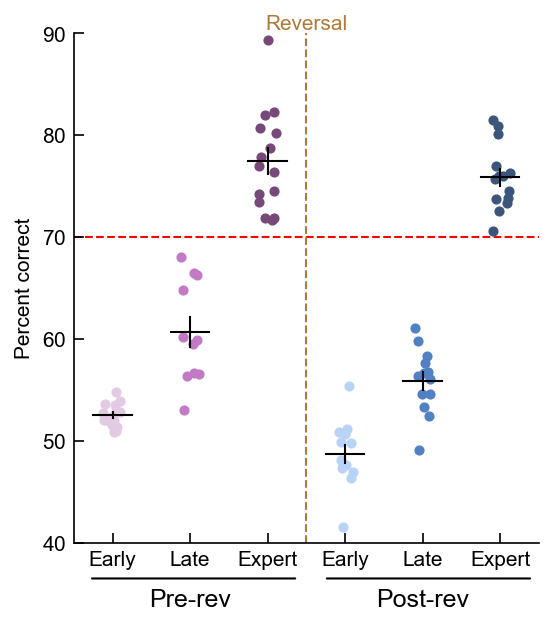

In [85]:
fig, ax = plt.subplots(figsize=(4,4.5))
data = [pre_early_pcs,pre_late_pcs,pre_expert_pcs,post_early_pcs,post_late_pcs,post_expert_pcs]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

width = 0.25
for idx,column in enumerate(data):
    Y = ilep.rmnan(column)*100
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    ax.scatter(X,Y,s=15,color=PHASE_COLORS[idx])
    
    mean = np.mean(Y)
    SEM = sem(Y)
    ax.plot([idx-width,idx+width],[mean]*2,color='k',lw=1)
    ax.plot([idx]*2,[mean-SEM,mean+SEM],color='k',lw=1)
    
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

ax.set_ylim([40,90])
ax.set_ylabel('Percent correct')

#ax.text(5,ax.get_ylim()[0],f"N = {len(animals)}\n",horizontalalignment='center',verticalalignment='bottom')
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
ax.axvline(2.5,linestyle='--',color=SWITCH_COLOR,lw=1,zorder=-9)
ax.axhline(70,linestyle='--',color='red',lw=1,zorder=-10)

ax.tick_params(length=5)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, 35.56511456700568, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
ax.text(xtick_pos_post, 35.56511456700568, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.485, -0.07),arrowprops=dict(arrowstyle='-', color='k'))
ax.annotate('', xy=(0.535, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='k'))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Performance over phases pc V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

In [27]:
-0.8749628968456478 + 0.6

-0.2749628968456478

In [29]:
-0.2749628968456478 / (2.5+0.6) * (90-40) + 40

35.56511456700568